In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [ ]:
train_dir = '/kaggle/input/sports-classification/train'
val_dir = '/kaggle/input/sports-classification/valid'
test_dir ='/kaggle/input/sports-classification/test'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 100
Класи: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'ring

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

100%|██████████| 422/422 [02:25<00:00,  2.90it/s]


Epoch 1/10:
Train Loss: 1.9059, Train Accuracy: 0.6462
Val Loss: 0.8377, Val Accuracy: 0.8440


100%|██████████| 422/422 [00:45<00:00,  9.36it/s]


Epoch 2/10:
Train Loss: 0.6709, Train Accuracy: 0.8789
Val Loss: 0.5537, Val Accuracy: 0.8740


100%|██████████| 422/422 [00:43<00:00,  9.67it/s]


Epoch 3/10:
Train Loss: 0.4208, Train Accuracy: 0.9264
Val Loss: 0.4662, Val Accuracy: 0.8820


100%|██████████| 422/422 [00:43<00:00,  9.64it/s]


Epoch 4/10:
Train Loss: 0.2951, Train Accuracy: 0.9561
Val Loss: 0.3878, Val Accuracy: 0.8980


100%|██████████| 422/422 [00:43<00:00,  9.60it/s]


Epoch 5/10:
Train Loss: 0.2168, Train Accuracy: 0.9724
Val Loss: 0.3821, Val Accuracy: 0.8920


100%|██████████| 422/422 [00:44<00:00,  9.52it/s]


Epoch 6/10:
Train Loss: 0.1637, Train Accuracy: 0.9808
Val Loss: 0.3489, Val Accuracy: 0.8980


100%|██████████| 422/422 [00:43<00:00,  9.65it/s]


Epoch 7/10:
Train Loss: 0.1279, Train Accuracy: 0.9877
Val Loss: 0.3384, Val Accuracy: 0.8940


100%|██████████| 422/422 [00:43<00:00,  9.64it/s]


Epoch 8/10:
Train Loss: 0.1008, Train Accuracy: 0.9919
Val Loss: 0.3215, Val Accuracy: 0.9120


100%|██████████| 422/422 [00:44<00:00,  9.49it/s]


Epoch 9/10:
Train Loss: 0.0856, Train Accuracy: 0.9939
Val Loss: 0.2960, Val Accuracy: 0.9180


100%|██████████| 422/422 [00:44<00:00,  9.54it/s]


Epoch 10/10:
Train Loss: 0.0718, Train Accuracy: 0.9945
Val Loss: 0.3079, Val Accuracy: 0.9140


In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

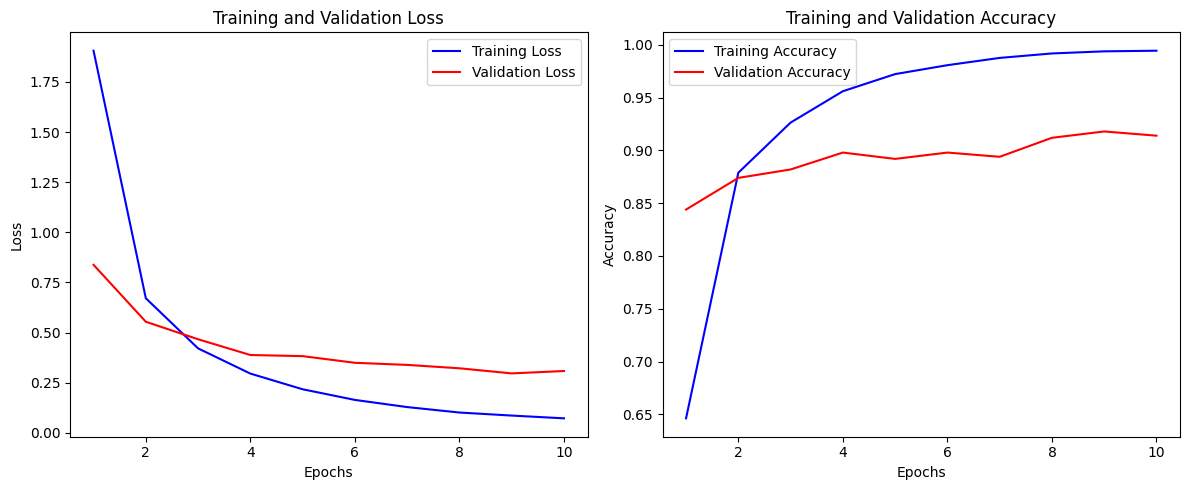

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


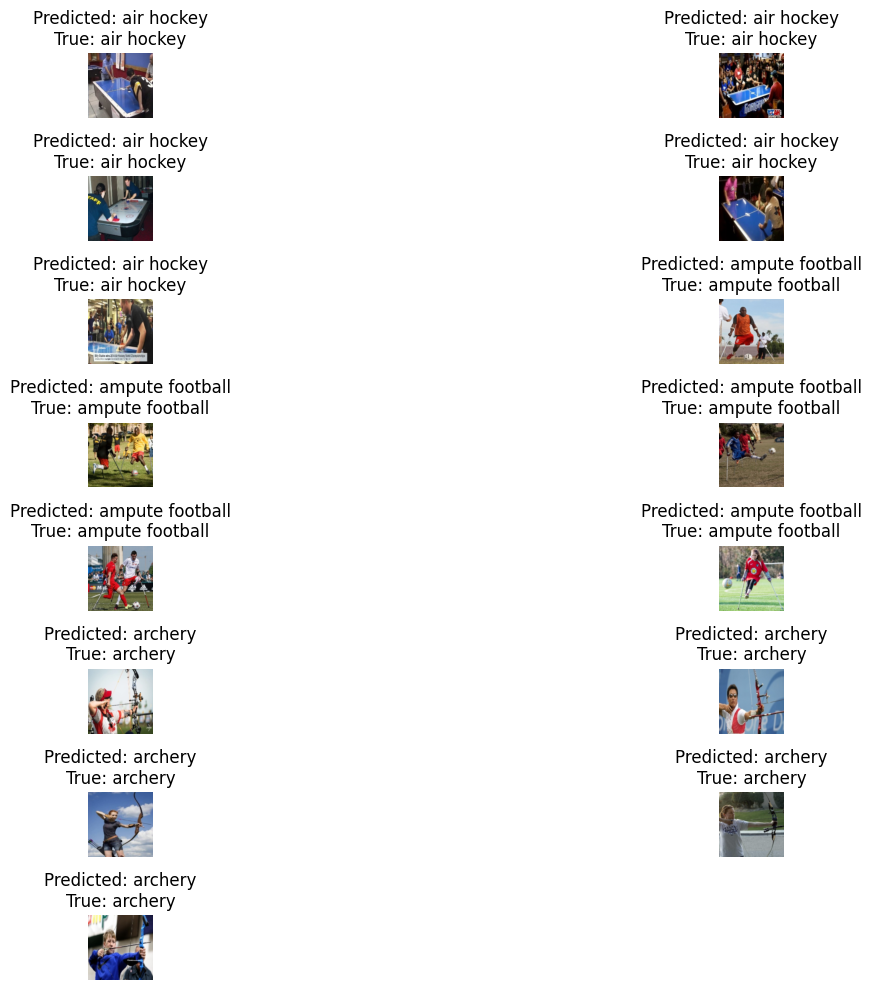

In [ ]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)


Висновок:
У цій лабораторній роботі ми працювали з задачами класифікації зображень, використовуючи попередньо натреновану модель ResNet-50. Після попередньої обробки даних і підготовки датасетів ми навчили модель на зображеннях зі спортивними категоріями. Завдяки трансферному навчанню ResNet-50 змогла досягти хороших результатів за кілька епох. Модель показала здатність ефективно розрізняти зображення різних класів, що свідчить про її ефективність у задачах комп’ютерного зору.